# UNIVERSIDAD ORT URUGUAY
**SANTIAGO BELZA - 286184**  
**VANESA ALLAN - 247079**

## Exploración de Métodos para Predicción de Tráfico Vehicular: Autorregresivos, Redes Recurrentes, Autoencoders y Modelos Basados en Grafos

### Contexto del Script de Análisis

El siguiente script en Python forma parte del proceso de análisis para la exploración de modelos de predicción de tráfico vehicular en el marco de la investigación realizada. Este script contiene la implementación de Stacked AutoEncoders y greedy layer wise pretraining.

### Librerías y carga de datos

In [17]:
import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [18]:
from google.colab import drive
drive.mount("/content/drive")
! cp "/content/drive/My Drive/01_ORT_Master_en_Big_Data/09_Tesis/El_principio_del_fin/07_Datos/Dataset/Datos_transito.csv" "/content/"
#! cp "/content/drive/My Drive/MasterBigData/Datos_transito.csv" .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
df = pd.read_csv('Datos_transito.csv')

In [20]:
df

,latitud,longitud,FechaHora,velocidad_agrupada,volumen_agrupada,dsc_avenida,key,zona
0,-34.897926,-56.165434,2023-09-01 00:00:00,0.000000,0.0,18 de Julio,-34.897926-56.165434,2
1,-34.897926,-56.165434,2023-09-01 00:15:00,0.000000,0.0,18 de Julio,-34.897926-56.165434,2
2,-34.897926,-56.165434,2023-09-01 00:30:00,0.000000,0.0,18 de Julio,-34.897926-56.165434,2
3,-34.897926,-56.165434,2023-09-01 00:45:00,0.000000,0.0,18 de Julio,-34.897926-56.165434,2
4,-34.897926,-56.165434,2023-09-01 01:00:00,0.000000,0.0,18 de Julio,-34.897926-56.165434,2
...,...,...,...,...,...,...,...,...
1206537,-34.862684,-56.212248,2023-10-31 23:00:00,25.333333,26.0,Zufriategui,-34.862684-56.212248,1
1206538,-34.862684,-56.212248,2023-10-31 23:15:00,25.000000,19.0,Zufriategui,-34.862684-56.212248,1
1206539,-34.862684,-56.212248,2023-10-31 23:30:00,29.333333,14.0,Zufriategui,-34.862684-56.212248,1
1206540,-34.862684,-56.212248,2023-10-31 23:45:00,21.666667,8.0,Zufriategui,-34.862684-56.212248,1


### Estudio de outliers

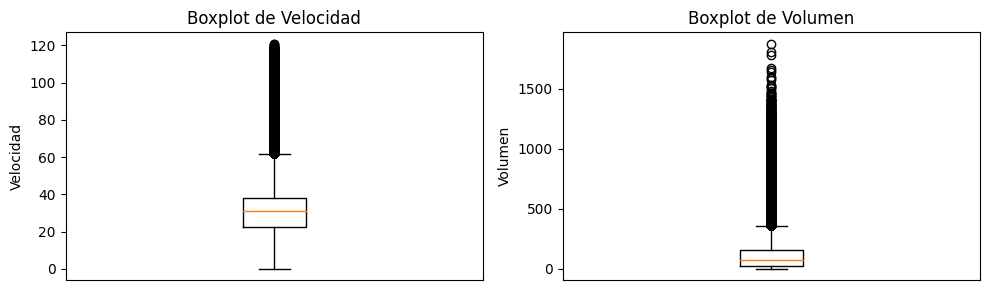

In [21]:
import matplotlib.pyplot as plt

# Crear un gráfico de boxplot para la velocidad agrupada y el volumen agrupado
plt.figure(figsize=(10, 3))

# Boxplot de velocidad agrupada
plt.subplot(1, 2, 1)  # Configuración para dos subgráficos en una fila
plt.boxplot(df['velocidad_agrupada'])
plt.title('Boxplot de Velocidad')
plt.ylabel('Velocidad')
plt.xticks([])  # Ocultar etiquetas en el eje x

# Boxplot de volumen agrupado
plt.subplot(1, 2, 2)
plt.boxplot(df['volumen_agrupada'])
plt.title('Boxplot de Volumen')
plt.ylabel('Volumen')
plt.xticks([])  # Ocultar etiquetas en el eje x

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
plt.show()

### Estudio de distribuciones

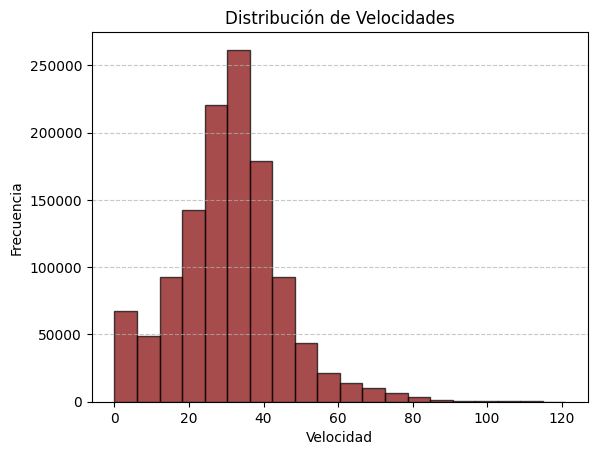

In [22]:
# Personaliza los colores
color_bordo = '#800000'  # Bordo oscuro
color_gris = '#808080'   # Gris oscuro

# Histograma de velocidad en tono de bordó
plt.hist(df['velocidad_agrupada'], bins=20, color=color_bordo, alpha=0.7, edgecolor='black')
plt.title('Distribución de Velocidades')
plt.xlabel('Velocidad')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

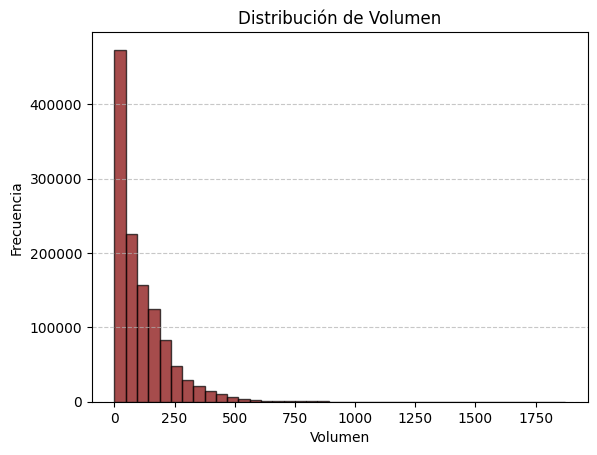

In [23]:
# Personaliza los colores
color_bordo = '#800000'  # Bordo oscuro
color_gris = '#808080'   # Gris oscuro

# Histograma de velocidad en tono de bordó
plt.hist(df['volumen_agrupada'], bins=40, color=color_bordo, alpha=0.7, edgecolor='black')
plt.title('Distribución de Volumen')
plt.xlabel('Volumen')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [24]:
print("Cantidad de detectores: ", df['key'].nunique())

Cantidad de detectores:  206


### Clusterización por distancia

In [25]:
# Definir los colores para cada zona
colores_zonas = {
    0: '#581E67',
    1: '#FFA500',
    2: '#2F748E',
    3: '#FF0000',
    4: '#7AD151',
    5: '#FDE725'
}

<ipython-input-26-b48774e1d9d7>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_zona['longitud'], df_zona['latitud'], color=color, label=f'Zona {zona}', cmap='viridis', s=20)


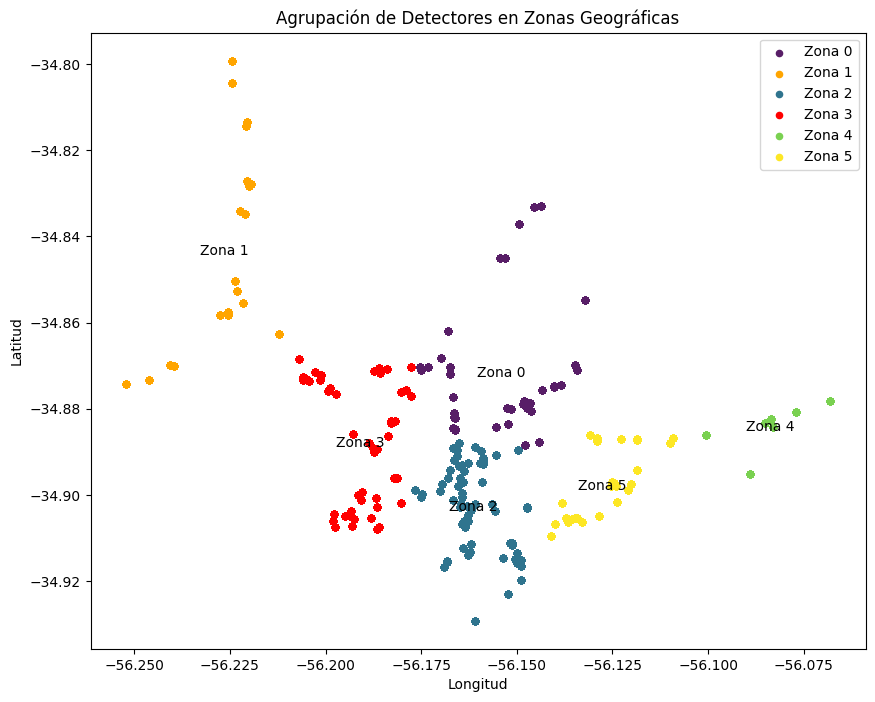

In [26]:
# Grafica los puntos en el mapa para visualizar las zonas
plt.figure(figsize=(10, 8))
for zona, color in colores_zonas.items():
    df_zona = df[df['zona'] == zona]
    plt.scatter(df_zona['longitud'], df_zona['latitud'], color=color, label=f'Zona {zona}', cmap='viridis', s=20)

# Agrega etiquetas a cada zona
for zona, color in colores_zonas.items():
    centroid = df[df['zona'] == zona][['longitud', 'latitud']].mean()
    plt.text(centroid['longitud'], centroid['latitud'], f'Zona {zona}', fontsize=10, ha='center', va='center')

plt.title('Agrupación de Detectores en Zonas Geográficas')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()
plt.show()


### Distribuciones temporales

In [27]:
df['FechaHora'] = pd.to_datetime(df['FechaHora'])

# Agrupa por fecha y hora y calcula el volumen y la velocidad promedio
filtro1 = (df['zona'] == 0)
filtro2 = (df['zona'] == 1)
filtro3 = (df['zona'] == 2)
filtro4 = (df['zona'] == 3)
filtro5 = (df['zona'] == 4)

agrupado1 = df[filtro1].groupby(df['FechaHora'].dt.strftime('%H'))['volumen_agrupada'].mean().reset_index()
agrupado2 = df[filtro2].groupby(df['FechaHora'].dt.strftime('%H'))['volumen_agrupada'].mean().reset_index()
agrupado3 = df[filtro3].groupby(df['FechaHora'].dt.strftime('%H'))['volumen_agrupada'].mean().reset_index()
agrupado4 = df[filtro4].groupby(df['FechaHora'].dt.strftime('%H'))['volumen_agrupada'].mean().reset_index()
agrupado5 = df[filtro5].groupby(df['FechaHora'].dt.strftime('%H'))['volumen_agrupada'].mean().reset_index()

agrupadoV1 = df[filtro1].groupby(df['FechaHora'].dt.strftime('%H'))['velocidad_agrupada'].mean().reset_index()
agrupadoV2 = df[filtro2].groupby(df['FechaHora'].dt.strftime('%H'))['velocidad_agrupada'].mean().reset_index()
agrupadoV3 = df[filtro3].groupby(df['FechaHora'].dt.strftime('%H'))['velocidad_agrupada'].mean().reset_index()
agrupadoV4 = df[filtro4].groupby(df['FechaHora'].dt.strftime('%H'))['velocidad_agrupada'].mean().reset_index()
agrupadoV5 = df[filtro5].groupby(df['FechaHora'].dt.strftime('%H'))['velocidad_agrupada'].mean().reset_index()

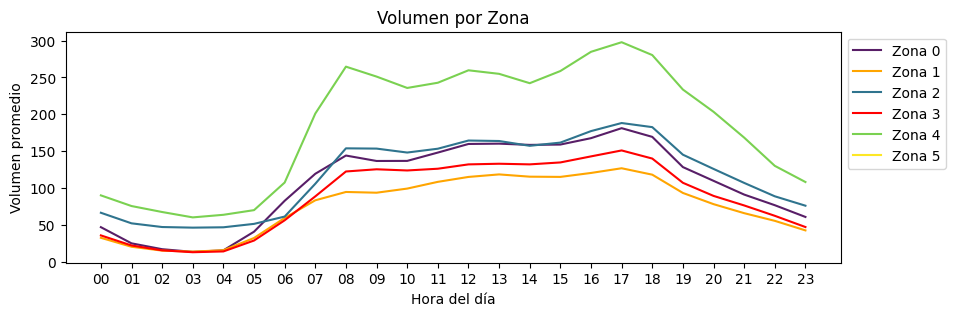

In [29]:
plt.figure(figsize=(10, 3))
for zona, color in colores_zonas.items():
    agrupado_zona = globals().get(f'agrupado{zona+1}')  # Acceder a los DataFrames agrupados por zona
    if agrupado_zona is not None:  # Verificar si el DataFrame existe
        plt.plot(agrupado_zona['FechaHora'], agrupado_zona['volumen_agrupada'], color=color, label=f'Zona {zona}')

plt.title('Volumen por Zona')
plt.xlabel('Hora del día')
plt.ylabel('Volumen promedio')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

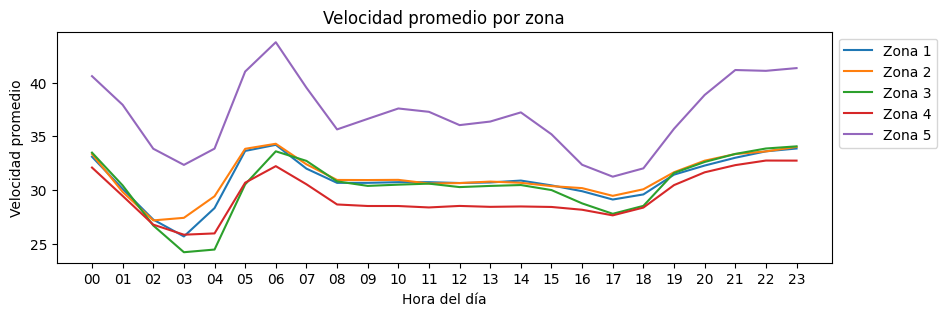

In [30]:
# Graficar velocidad promedio por zona
plt.figure(figsize=(10, 3))

# Graficar velocidad promedio por zona
plt.plot(agrupadoV1['FechaHora'], agrupadoV1['velocidad_agrupada'], label='Zona 1')
plt.plot(agrupadoV2['FechaHora'], agrupadoV2['velocidad_agrupada'], label='Zona 2')
plt.plot(agrupadoV3['FechaHora'], agrupadoV3['velocidad_agrupada'], label='Zona 3')
plt.plot(agrupadoV4['FechaHora'], agrupadoV4['velocidad_agrupada'], label='Zona 4')
plt.plot(agrupadoV5['FechaHora'], agrupadoV5['velocidad_agrupada'], label='Zona 5')


# Añadir etiquetas y título
plt.xlabel('Hora del día')
plt.ylabel('Velocidad promedio')
plt.title('Velocidad promedio por zona')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Mostrar gráfico
plt.show()